In [1]:
import torch
import numpy as np
from datasets import FHB_Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings

def normHSI(R, eps=1e-6, stat=False):
    if isinstance(R, torch.Tensor):
        rmax, rmin = torch.max(R), torch.min(R)
        R = (R - rmin)/(rmax - rmin + eps)
    elif isinstance(R, np.ndarray):
        rmax, rmin = np.max(R), np.min(R)
        R = (R - rmin)/(rmax - rmin + eps)
    else:
        warnings.warn("Unsupport data type of input HSI")
        return
    if stat:
        return R, rmax, rmin
    return R

In [2]:
dataset = FHB_Dataset(data_dir="beyond-visible-spectrum-ai-for-agriculture-2024/ICPR01/kaggle", transform=None, noisy=False, rotate=False)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [3]:
# wavelength between 490 ~ 894 
# 630 nm for red, 532 nm for green, and 465 nm for blue light. => [35, 11, 0] 
# spatial resolution close to 4cm per pixel
hsi_1, hsi_0 = None, None
org_hsi1, org_hsi0 = None, None
spec_1, spec_0 = [], []
for data in dataloader:
    img, label = data
    if label == 0:
        # org_hsi0 = img.squeeze(0)
        org_hsi0 = normHSI(img.squeeze(0))
        hsi_0 = normHSI(img)
        hsi_0 = hsi_0[:, [35,11,0],:,:].squeeze(0).permute(1,2,0)
    elif label == 1:
        # org_hsi1 = img.squeeze(0)
        org_hsi1 = normHSI(img.squeeze(0))
        hsi_1 = normHSI(img)
        hsi_1 = hsi_1[:, [35,11,0],:,:].squeeze(0).permute(1,2,0)
    
    if hsi_1 is not None and hsi_0 is not None :
        break
for i in range(org_hsi1.shape[0]):
    mean1 = torch.mean(org_hsi1[i,:,:])
    spec_1.append(mean1)
    mean0 = torch.mean(org_hsi0[i,:,:])
    spec_0.append(mean0)

C:\Users\user\AppData\Local\Temp\ipykernel_48696\589727676.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use(['seaborn-bright'])


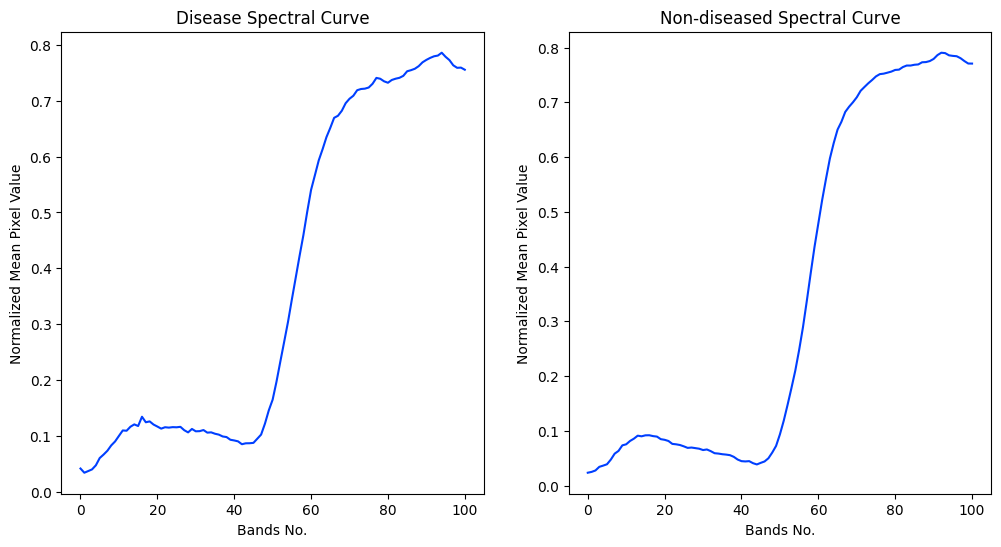

In [4]:
import matplotlib as mpl
mpl.style.use(['seaborn-bright'])

# ymin, ymax = 0, 1
# ax = plt.subplot(1,2,1)
# plt.imshow(hsi_1)
# plt.axis('off')
# ax.set_title('2')
# ax = plt.subplot(1,2,2)
# plt.imshow(hsi_0)
# plt.axis('off')
# ax.set_title('1') 
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plt.plot(range(len(spec_1)), spec_1)
# ax.set_ylim([ymin, ymax])
ax.set_title('Disease Spectral Curve')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')
ax = plt.subplot(1,2,2)
plt.plot(range(len(spec_0)), spec_0)
# ax.set_ylim([ymin, ymax])
ax.set_title('Non-diseased Spectral Curve')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')
plt.show()

In [5]:
import pandas as pd

spec_data = []
for data in dataloader:
    img, label = data
    org_img = img.squeeze(0)
    img = normHSI(img).squeeze(0)
    spec = []
    for i in range(img.shape[0]):
        mean = torch.mean(img[i,:,:])
        spec.append(mean.item())
    spec.append(label.item())
    spec_data.append(spec)

df = pd.DataFrame(spec_data, columns=[*range(101), 'label'])

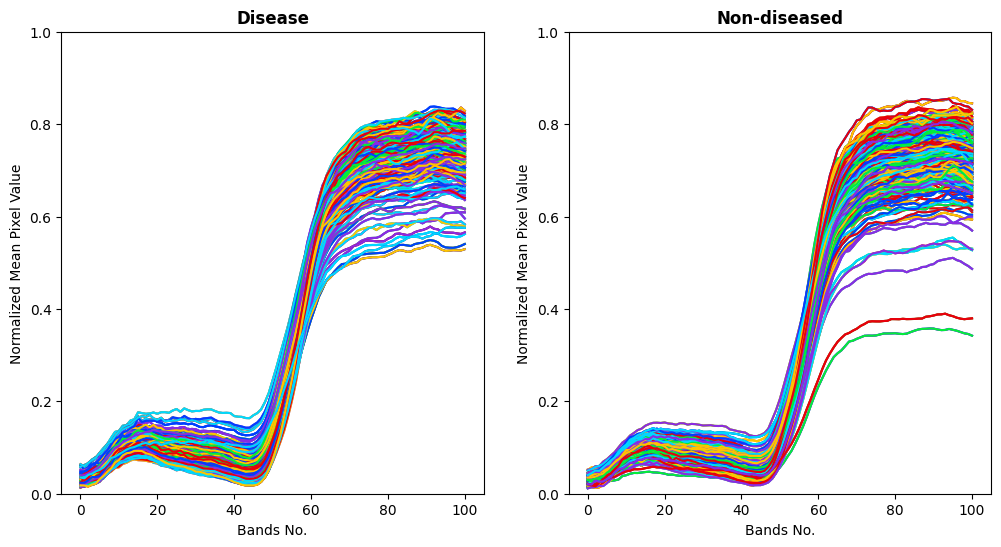

In [6]:
ymin, ymax = 0, 1

plt.figure(figsize=(12,6))

df_d = df[df['label']==1].drop('label', axis=1)
df_nd = df[df['label']==0].drop('label', axis=1)

ax = plt.subplot(1,2,1)
for i in range(df_d.shape[0]):
    ax.plot(range(101), df_d.iloc[i])
ax.set_ylim([ymin, ymax])
ax.set_title('Disease', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')

ax = plt.subplot(1,2,2)
for i in range(df_nd.shape[0]):
    ax.plot(range(101), df_nd.iloc[i])
ax.set_ylim([ymin, ymax])
ax.set_title('Non-diseased', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')

plt.show()


## LightGBM ##

In [7]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop('label', axis=1)  
y = df['label']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=810)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss', 
    'boosting': 'gbdt',  
    'num_leaves': 30,    
    'learning_rate': 0.01, 
    'verbose': -1
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)

y_pred = model.predict(X_test)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]  
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')


ModuleNotFoundError: No module named 'lightgbm'

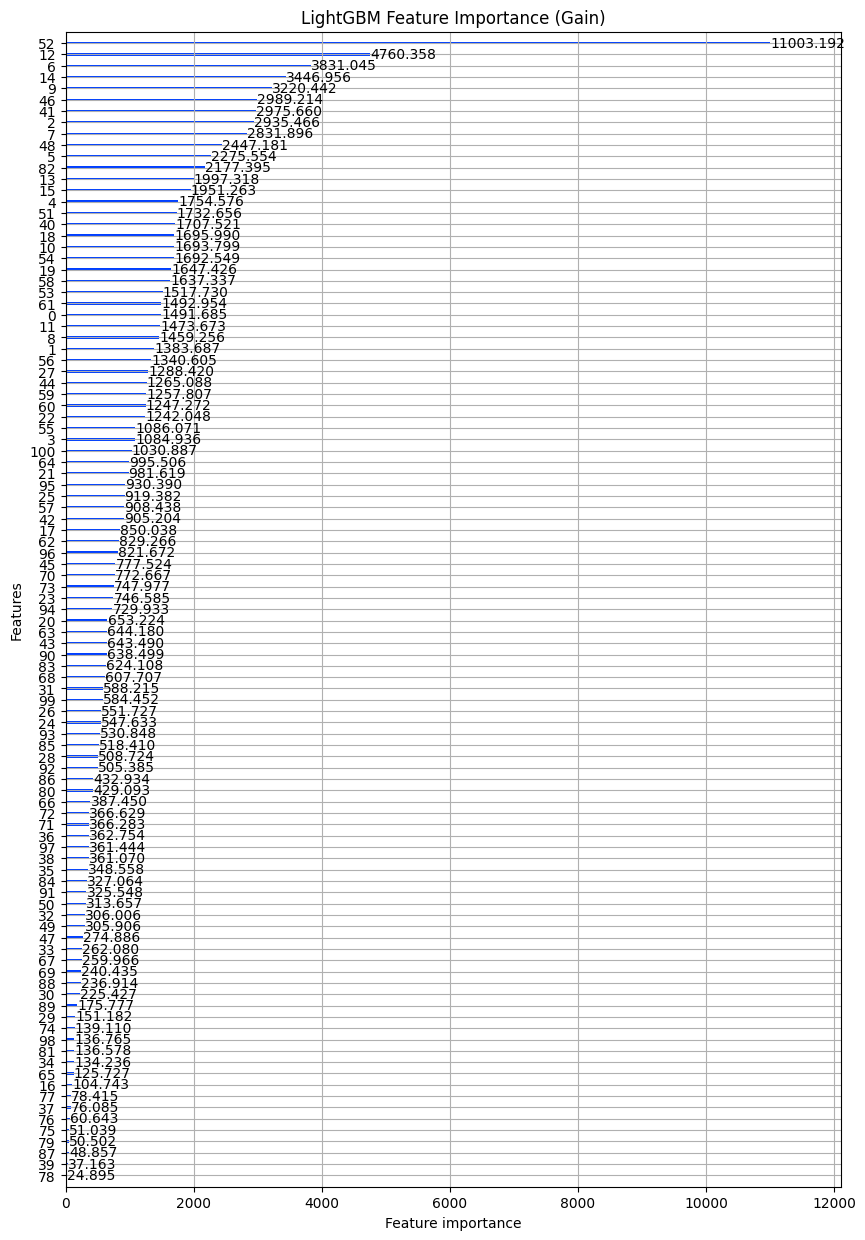

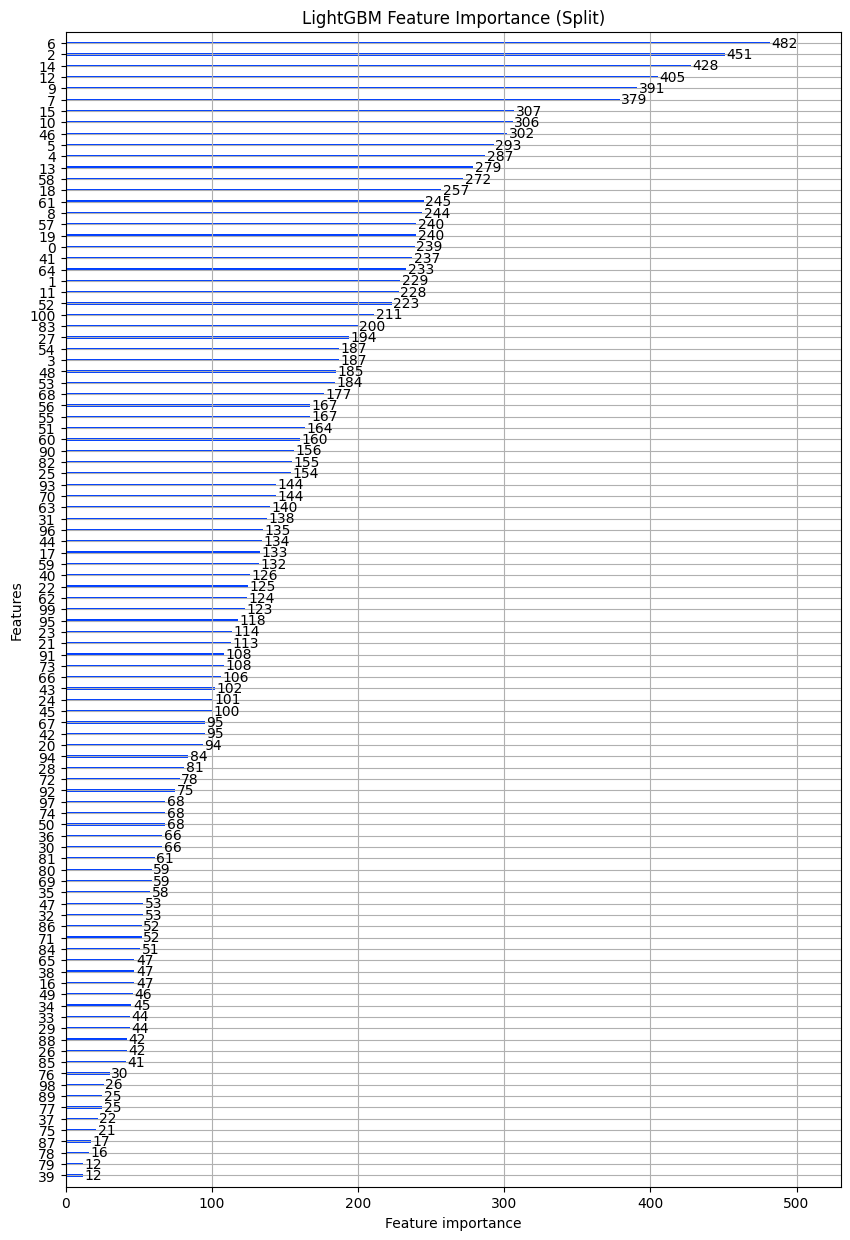

In [113]:
lgb.plot_importance(model, importance_type="gain", figsize=(10,15), title="LightGBM Feature Importance (Gain)")
plt.show()
lgb.plot_importance(model, importance_type="split", figsize=(10,15), title="LightGBM Feature Importance (Split)")
plt.show()


## K Bands Selection (for LightGBM) ##

In [114]:
gain_importance = model.feature_importance(importance_type='gain')

gain_importance_df = pd.DataFrame({'Band No.':  range(101), 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

    Band No.          Gain
52        52  11003.192350
12        12   4760.358164
6          6   3831.044899
14        14   3446.955985
9          9   3220.441574
..       ...           ...
75        75     51.038505
79        79     50.501934
87        87     48.857438
39        39     37.163088
78        78     24.895012

[101 rows x 2 columns]


In [115]:
spec_data2 = []
for data in dataloader:
    img, label = data
    img = img.squeeze(0)
    spec = []
    for i in gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:15]:
        mean = torch.mean(img[i,:,:])
        spec.append(mean.item())
    spec.append(label.item())
    spec_data2.append(spec)

df2 = pd.DataFrame(spec_data2, columns=[*range(15), 'label'])

X2 = df2.drop('label', axis=1)  
y2 = df2['label']               

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.05, random_state=810)

train_data2 = lgb.Dataset(X_train2, label=y_train2)
test_data2 = lgb.Dataset(X_test2, label=y_test2)

params2 = {
    'objective': 'binary',  
    'metric': 'binary_logloss', 
    'boosting': 'gbdt',  
    'num_leaves': 30,    
    'learning_rate': 0.01,
    'verbose': -1
}

model2 = lgb.train(params2, train_data2, valid_sets=[test_data2], num_boost_round=500)

y_pred2 = model2.predict(X_test2)
y_pred_binary2 = [1 if x > 0.5 else 0 for x in y_pred2] 
accuracy2 = accuracy_score(y_test2, y_pred_binary2)
print(f'Accuracy: {accuracy2:.2f}')


Accuracy: 1.00


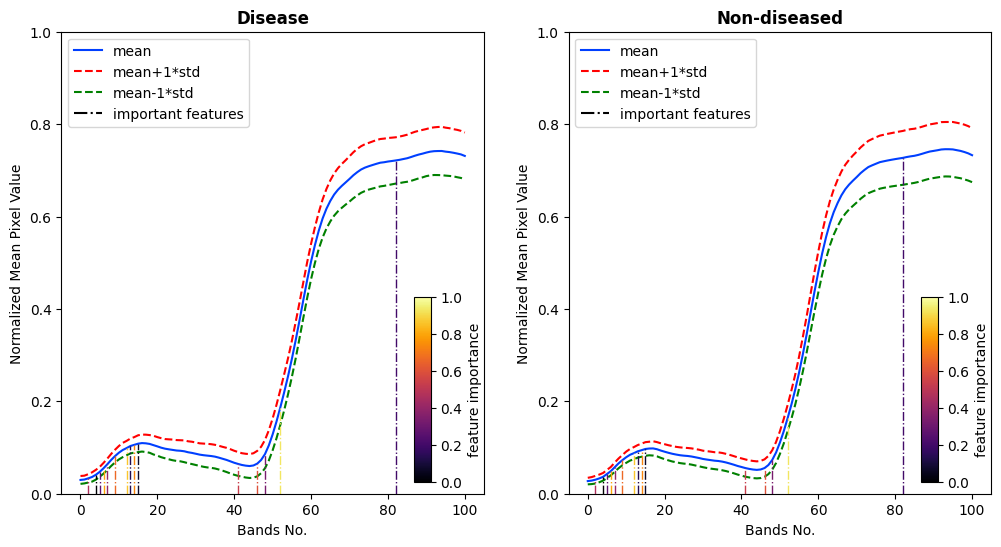

In [135]:
from operator import add, neg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D


plt.figure(figsize=(12,6))

df_d = df[df['label']==1].drop('label', axis=1)
df_nd = df[df['label']==0].drop('label', axis=1)

mean1, mean0 = [], []
std1, std0 = [], []

ax = plt.subplot(1,2,1)
for i in range(101):
   mean1.append(df_d[i].mean())
   std1.append(df_d[i].std())
ax.plot(range(101), mean1, label='mean')
ax.plot(range(101), list(map(add, mean1, std1)), 'r--', label='mean+1*std')
ax.plot(range(101), list(map(add, mean1, list(map(neg, std1)))), 'g--', label='mean-1*std')
ax.set_ylim([ymin, ymax])
ax.set_title('Disease', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:15]):
   ax.axvline(b, linewidth=1, color=plt.cm.inferno((15-i-1)/15), ymax=mean1[b], linestyle='-.')
   # plt.text(b, mean1[b] + 0.02, f'{mean1[b]:.2f}', fontsize=8, color='black', ha='center')
axins = inset_axes(plt.gca(), width="5%", height="40%", loc='lower right', bbox_to_anchor=(0.09, 0.01, 0.8, 1), bbox_transform=plt.gca().transAxes)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm, cax=axins, label='feature importance')
feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

ax = plt.subplot(1,2,2)
for i in range(101):
   mean0.append(df_nd[i].mean())
   std0.append(df_nd[i].std())
ax.plot(range(101), mean0, label='mean')
ax.plot(range(101), list(map(add, mean0, std0)), 'r--', label='mean+1*std')
ax.plot(range(101), list(map(add, mean0, list(map(neg, std0)))), 'g--', label='mean-1*std')
ax.set_ylim([ymin, ymax])
ax.set_title('Non-diseased', fontweight='bold')
ax.set_ylabel('Normalized Mean Pixel Value')
ax.set_xlabel('Bands No.')
for i, b in enumerate(gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:15]):
   ax.axvline(b, linewidth=1, color=plt.cm.inferno((15-i-1)/15), ymax=mean0[b], linestyle='-.')
   # plt.text(b, mean0[b] + 0.02, f'{mean0[b]:.2f}', fontsize=8, color='black', ha='center', rotation=30)
axins = inset_axes(plt.gca(), width="5%", height="40%", loc='lower right', bbox_to_anchor=(0.09, 0.01, 0.8, 1), bbox_transform=plt.gca().transAxes)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
feaimplb = Line2D([0], [0], label='important features', color='black', linestyle='-.')
plt.colorbar(sm, cax=axins, label='feature importance')
handles, labels = ax.get_legend_handles_labels()
handles.append(feaimplb) 
ax.legend(handles=handles, loc='upper left')

plt.show()

In [123]:
for i in gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:15]:
    print(f'{mean1[i] - mean0[i]:.3f}')

0.023
0.011
0.006
0.012
0.009
0.010
0.009
0.003
0.007
0.013
0.005
-0.006
0.012
0.011
0.004


In [124]:
gain_importance_df.sort_values(by='Gain', ascending=False)['Band No.'][:15]

52    52
12    12
6      6
14    14
9      9
46    46
41    41
2      2
7      7
48    48
5      5
82    82
13    13
15    15
4      4
Name: Band No., dtype: int64

## Support Vector Machine (SVM)

In [125]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=810)

clf = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma=0.1,C=10.0))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc_svm:.2f}')

Accuracy: 1.00
